# 20201018 - Exploratory Data Analysis

Topic: Hierarchical clustering

This report describes a preliminary analysis of hierarchical clustering. The Python library scipy was used for the agglomerative clustering process and for creating the dendrogram. Later the silhouette was calculated in order to assess the clustering process quality.

## Imports and functions

The first step is to import the useful modules and define functions to be used throughout the file. Each of the functions used contains docstrings with specific details.

In [1]:
import os, inspect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [2]:
def prepare_data(flights_folder, n_observations):
    """
    Reads flight data and returns a dataframe containing flight id and the
    flight vector x.

    x = [x_1_t1,x_1_t2,...,x_1_tn,...,x_i_tj,...,x_m_t1,x_m_t2,...,x_m_tn]

    where:
        x_i_tj  <- value of the i-th flight parameter at time tj.
        m       <- total number of parameters
        n       <- number of samples for every parameter

    Similar to Cluster AD Flight, defined by Li and Hansman (2013).

    References:
    
    Li, Lishuai, and R John Hansman. 2013. “Anomaly Detection in Airline 
    Routine Operations Using Flight Data Recorder Data.” PhD thesis, 
    Cambridge, MA: Massachusetts Institute of Technology.
    """
    flights_list = os.listdir(flights_folder)

    flight_vector = []
    for flight in flights_list:
        df_flight = pd.read_csv(os.path.join(flights_folder, flight))
        touchdown_index = get_touchdown(df_flight)
        df_analysis = df_flight[touchdown_index-n_observations:touchdown_index]
        column_filter = df_flight.columns.values[df_flight.columns != 'Time']
        flight_vector.append(
                pd.melt(df_analysis.loc[:, column_filter])['value'].to_numpy()
                )

    return pd.DataFrame({'flight_id': flights_list, 'flight_vector': flight_vector})


def get_touchdown(df):
    """
    Calculates instance of touchdown (landing).
    """
    df = df.copy()
    return df.iloc[df['Altitude'].idxmax():][df['Altitude'] <= 2].index[0]


def plot_silhouette(sample_silhouette_values, n_clusters):
    """
    Plots the silhouette of the clustering process.
    
    Ref:
        https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

    Parameters
    ----------
    sample_silhouette_values : numpy.ndarray
        Silhouette coefficient for each sample.

    Returns
    -------
    fig : Figure
        Matplotlib figure object.
    ax : axis
        Matplotlib axis object.

    """
    fig, ax = plt.subplots()
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[labels == i]
    
        ith_cluster_silhouette_values.sort()
    
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
    
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
    
        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    
    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks(np.linspace(-1,1,11))
    
    plt.show()
    
    return fig, ax

## Inputs

The first step in the analysis is to import the flight data and preprocess it. The preprocessing steps consist on selecting only a portion of a given flight, which is done by subsetting n_observations before the touchdown. The dataframe is then melted as described by the function **prepare_data** so the flight vector is obtained.

In [3]:
currentdir = os.path.dirname(
    os.path.abspath(
        inspect.getfile(
            inspect.currentframe()
        )
    )
)

flights_folder = os.path.join(os.path.dirname(os.path.dirname(currentdir)), 'input_flights')
df_flights = prepare_data(flights_folder, n_observations=600)
df_flights['flight_id_reduced'] = ['flight_'+str(i) for i in range(len(df_flights))] # reduced id add for plotting the dendrogram

print(df_flights.head())

<ipython-input-2-9cb449e7d225>:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df.iloc[df['Altitude'].idxmax():][df['Altitude'] <= 2].index[0]
                              flight_id  \
0  1166aa78cce1c3ef7bc246b3749eaee8.csv   
1  12fdaef5792eb79ae2685ffffc15efe1.csv   
2  135e97c93f39fed8ef95596ac27fcb41.csv   
3  142c58656bb4a84bebeef6456f454543.csv   
4  1458983def9bb5a89663afb7289d732c.csv   

                                       flight_vector flight_id_reduced  
0  [12696.0, 12675.0, 12658.0, 12648.0, 12640.0, ...          flight_0  
1  [15712.0, 15700.0, 15671.0, 15662.0, 15625.0, ...          flight_1  
2  [14920.0, 14930.0, 14917.0, 14894.0, 14859.0, ...          flight_2  
3  [13498.0, 13496.0, 13472.0, 13463.0, 13434.0, ...          flight_3  
4  [12409.0, 12412.0, 12396.0, 12376.0, 12382.0, ...          flight_4  


## Preparing data for clustering

Next the data is prepared to be compatible with the sci-kit learn library. The dataframe *flight_vector* column is converted to a numpy array in which each row is a flight and each column is a feature - in this case, a flight data parameter in a given instant.

Afterwards the StandardScaler transformer standardizes the data by centering it (subtraction of the mean) and scaling it to unit variance (more info: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

A further necessary step is dimension reduction although it is not explored in this analysis which focuses only on the silhouette coefficients.

In [4]:
X = np.empty([len(df_flights.flight_vector.to_numpy()), 9000])
i = 0
for nparray in df_flights.flight_vector.to_numpy():
    X[i, :] = nparray
    i += 1

scaler = StandardScaler()
X = scaler.fit_transform(X)

## Clustering

Scipy's linkage function was used to perform agglomerative clustering (https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html).

The output linkage matrix is then used as an input for the dendrogram function, which displays the clustering results on a plot. Finally the silhouette is calculated with sklearn's silhouette_score and silhouette_sample.


In [5]:
mergings=linkage(X, method='complete')

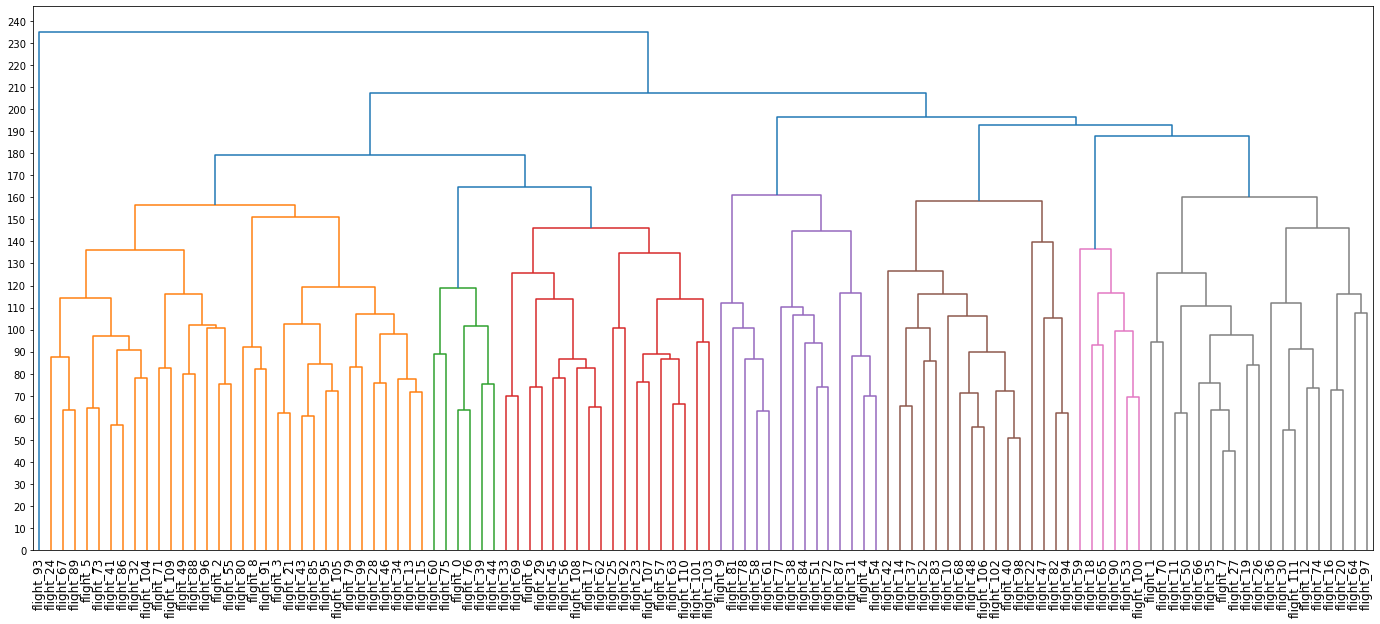

In [6]:
fig, ax = plt.subplots()
dendrogram(mergings,
           labels=df_flights['flight_id_reduced'].to_list(),
           leaf_rotation=90,
           leaf_font_size=12)
fig.set_size_inches(24, 10)
plt.yticks(range(0,250,10))
plt.show()

In [7]:
labels = fcluster(mergings, 150, criterion='distance')

Average silhouette: 0.062


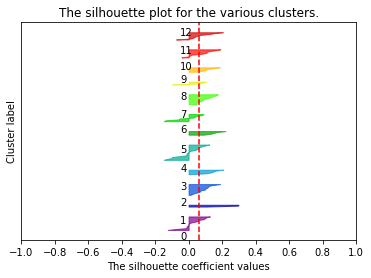

In [8]:
# Updating flights df with cluster labels
df_flights['cluster'] = labels
try:
    silhouette_avg = silhouette_score(X, labels)
    sample_silhouette_values = silhouette_samples(X, labels)
except:
    silhouette_avg = np.nan
    sample_silhouette_values = []

if silhouette_avg is not np.nan:
    df_flights['silhouette'] = sample_silhouette_values
    print('Average silhouette: {}'.format(round(silhouette_avg, 3)))
    plot_silhouette(sample_silhouette_values, len(list(set(labels))))

## Conclusions

Albeit interesting, quick and visually effective, the hierarchical clustering didn't provide good results at first, as shown by the silhouette plots. However an attempt at better results should be investigated within a complete process - inclusive of a dimension reduction step, e.g. - with a superior flight data source.